# ポアソン混合モデル

「ベイズ推論による機械学習入門」p.128~を参照．

こちらも参考になる．  
http://machine-learning.hatenablog.com/entry/2016/07/31/192012

In [1]:
!date

2019年 8月25日 日曜日 14時17分53秒 JST


In [73]:
%matplotlib inline
%matplotlib nbagg

import warnings
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats, special

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# ポアソン混合分布

In [3]:
class PoissonMixture:
    """
    Poisson Mixture model

    p(x, z, lmd, pi) = p(x|z, lmd)p(z|pi)p(lmd)p(pi)
    
    p(pi) = Dir(pi|alpha)
    p(lmd) = Gam(lmd_d,k|a, b)
    p(z|pi) = Cat(z_n|pi)
    p(x|z, lmd) = Poi(x_n,d|lmd_d,k)^(z_n,k)
    """
    
    def __init__(self, d, k, alpha=[10., 10., 10.], a=1., b=1.):
        # Dimension
        self.d = d
        self.k = k
        
        # Prior
        self.alpha = np.array(alpha)
        self.a = a
        self.b = b
        
    def sample_data(self, n=10):
        pi = np.random.dirichlet(self.alpha)
        lmd = np.array([[np.random.gamma(self.a, 1 / self.b) for d in range(self.d)]
                        for k in range(self.k)])
        z = np.array([np.random.choice(self.k, p=pi) for _ in range(n)])
        x = np.array([[np.random.poisson(lmd[z[i], j]) for j in range(self.d)] 
                      for i in range(n)])

        return x, z

# 人口データのシミュレート

In [4]:
# Model
D = 2
K = 4
alpha = 100.0 * np.ones(K)
a = 1.0
b = 0.01
pmm = PoissonMixture(D, K, alpha, a, b)

#### 潜在変数の持つ値で色分けをしている．

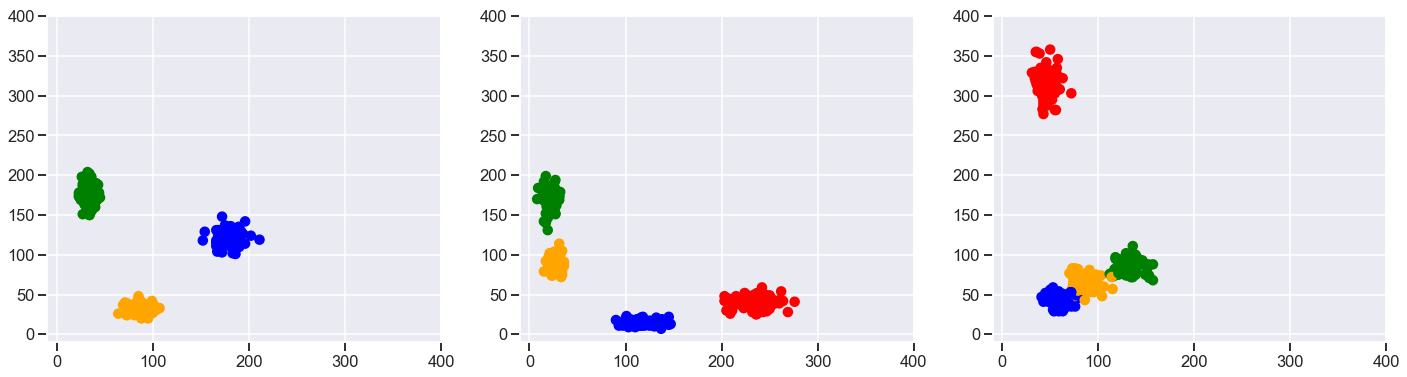

In [5]:
N = 300
colors = np.array(['b', 'r', 'g', 'orange'])
plt.figure(figsize=(24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    data, z = pmm.sample_data(N)

    # Plot
    plt.scatter(data[:, 0], data[:, 1], color=colors[z])
    plt.xlim([-10, 400])
    plt.ylim([-10, 400])
plt.show()

# 学習したいデータ

実際には，潜在変数は与えられない．

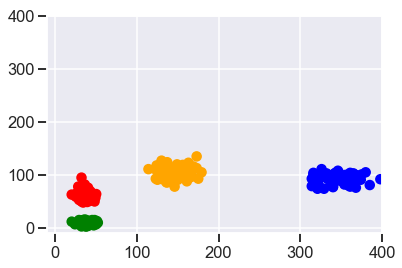

In [17]:
N = 300
plt.figure()
x_gen, z_gen = pmm.sample_data(N)

# Plot
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=colors[z_gen])
plt.xlim([-10, 400])
plt.ylim([-10, 400])
plt.show()

# Gibbs Sampling

In [75]:
class PMMGibbs(PoissonMixture):
    def __init__(self, d, k, alpha=[10., 10., 10.], a=1., b=1.):
        super().__init__(d, k, alpha, a, b)
        
        self.pi = np.random.dirichlet(self.alpha)
        self.lmd = np.array([[np.random.gamma(self.a, 1 / self.b) for d in range(self.d)]
                             for k in range(self.k)])
        self.z = None
        
    def inference(self, x, max_iter=50):
        N = len(x)
        for _ in range(max_iter):

            eta = np.array([[np.sum(x[n] * np.log(self.lmd[k]))
                                    - self.lmd[k].sum() + np.log(self.pi[k])
                             for k in range(self.k)]
                            for n in range(N)])
            eta -= special.logsumexp(eta)

            #self.z

In [76]:
model = PMMGibbs(D, K, alpha, a, b)
model.inference(x_gen, 1)

[[ 985.78886603 1089.36144191  492.37866214 1092.81470981]
 [  -5.3328524   216.81897937  186.68704877  161.7545169 ]
 [1923.18116488 1813.91228522  531.42053251 1889.42764452]
 ...
 [-295.09303461  -68.84973116   21.37716995 -135.9459815 ]
 [ 817.2723037   945.79336024  452.29203266  938.50236257]
 [ 835.00756118  956.59108327  445.80178819  951.14670637]]
[[-1313.98355251 -1210.41097664 -1807.39375641 -1206.95770874]
 [-2305.10527094 -2082.95343917 -2113.08536978 -2138.01790165]
 [ -376.59125367  -485.86013333 -1768.35188603  -410.34477403]
 ...
 [-2594.86545316 -2368.6221497  -2278.39524859 -2435.71840004]
 [-1482.50011484 -1353.9790583  -1847.48038588 -1361.27005598]
 [-1464.76485736 -1343.18133527 -1853.97063035 -1348.62571217]]


In [74]:
? special.logsumexp

Signature:  special.logsumexp(a, axis=None, b=None, keepdims=False, return_sign=False)
Docstring:
Compute the log of the sum of exponentials of input elements.

Parameters
----------
a : array_like
    Input array.
axis : None or int or tuple of ints, optional
    Axis or axes over which the sum is taken. By default `axis` is None,
    and all elements are summed.

    .. versionadded:: 0.11.0
keepdims : bool, optional
    If this is set to True, the axes which are reduced are left in the
    result as dimensions with size one. With this option, the result
    will broadcast correctly against the original array.

    .. versionadded:: 0.15.0
b : array-like, optional
    Scaling factor for exp(`a`) must be of the same shape as `a` or
    broadcastable to `a`. These values may be negative in order to
    implement subtraction.

    .. versionadded:: 0.12.0
return_sign : bool, optional
    If this is set to True, the result will be a pair containing sign
    information; if False, results